\# Developer: Ali Hashaam (ali.hashaam@initos.com) <br>
\# 3rd February 2019 <br>

\# © 2019 initOS GmbH <br>
\# License MIT <br>


\# Library for TSVM and SelfLearning taken from https://github.com/tmadl/semisup-learn <br>
\# Thanks to the authors for brilliant work


In [1]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from __future__ import division
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from frameworks.SelfLearning import *
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
regex_square_brackets = re.compile(r'(\[)|(\])')

In [4]:
bugs = pd.read_csv('../datasets/lexical_semantic_preprocessed_mantis_bugs_less_columns_with_class_expansion.csv')
bug_notes = pd.read_csv('../datasets/lexical_semantic_preprocessed_mantis_bugnotes.csv')

In [5]:
bug_notes['bug_note'] = bug_notes['bug_note'].str.replace(regex_square_brackets, '')
bugs['additional_information'] = bugs['additional_information'].str.replace(regex_square_brackets, '')
bugs['description'] = bugs['description'].str.replace(regex_square_brackets, '')
bugs['summary'] = bugs['summary'].str.replace(regex_square_brackets, '')
df_bug_note_table = bug_notes.groupby(['bug_id'])['bug_note'].apply(','.join).to_frame('bug_notes').reset_index()
result = pd.merge(bugs, df_bug_note_table, how='left', left_on='id', right_on='bug_id')
result['textual_data'] = result['summary'].fillna('') + ',' + result['description'].fillna('') + ',' + result['additional_information'].fillna('') + ',' + result['bug_notes'].fillna('')

In [6]:
result['textual_data'] = result['textual_data'].str.replace(" ", "")
result.sort_values(by=['class'], inplace=True)
result.reset_index(drop=True, inplace= True)

In [7]:
result.loc[result['class']=='critical', 'class'] = 0
result.loc[result['class']=='non-critical', 'class'] = 1
unlabelled_index = result[(result['class'].isnull())].index
labelled_index = result[~(result['class'].isnull())].index
print result['class'].value_counts()

1    2591
0    1104
Name: class, dtype: int64


In [8]:
def apply_self_learning_model(X_train, Y_train, X_test, Y_test, X_U, sklearn_classifier, classifier, n_o_f, iteration):
    X = np.vstack((X_train, X_U))
    Y_U = np.full((X_U.shape[0], ), -1, dtype=float)
    Y = np.concatenate((Y_train, Y_U)).astype(float)
    if classifier=='SVM':
        C=[1/100, 1/10, 1, 10, 100]
        gamma=[]
        gamma += [1/X.shape[1]]
        kernel=['rbf']
        params_grid = [
          {'C': C,
           'gamma': gamma,
           'kernel': kernel}
        ]
        gs = GridSearchCV(SVC(probability=True), params_grid, cv=3)
        gs.fit(X, Y)
        sklearn_classifier = gs.best_estimator_
    slm = SelfLearningModel(sklearn_classifier)
    slm.fit(X, Y)
    joblib.dump(slm, 'models/selfLearning_{}_{}_{}.pkl'.format(classifier, n_o_f, iteration))
    joblib.dump(X_test, 'models/X_test_{}_{}_{}.pkl'.format(classifier, n_o_f, iteration))
    joblib.dump(Y_test, 'models/Y_test_{}_{}_{}.pkl'.format(classifier, n_o_f, iteration))
    score = slm.score(X_test, Y_test.astype(float))
    return score

In [9]:
def SLM(X_l, Y_l, X_U, sklearn_classifier, classifier, n_o_f):
    stratified_shuffle_split = StratifiedShuffleSplit(n_splits=3, test_size=0.6, random_state=0)
    scores = []
    iteration = 1
    for train_index, test_index in stratified_shuffle_split.split(X_l, Y_l):
        X_train = X_l[train_index].copy()
        Y_train = Y_l[train_index].copy()
        X_test = X_l[test_index].copy()
        Y_test = Y_l[test_index].copy()
        score = apply_self_learning_model(X_train, Y_train, X_test, Y_test, X_U, 
                                          sklearn_classifier, classifier, n_o_f, iteration)
        scores.append(score)
        iteration += 1
    print "self-learning {} average score: {}".format(classifier, np.mean(scores))

In [10]:
def main(df, sklearn_classifier, features_list, classifier, unlabelled_index, labelled_index):
    results = {}
    for no_of_features in features_list:
        print("""####################### Running for Number of features {} ############################""".format(no_of_features))
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_of_features, stop_words='english')
        X = tfidf_vectorizer.fit_transform(df['textual_data']).toarray()
        Y = np.array(df['class'])
        #print("members for classes {}".format(",".join("(%s,%s)" % tup for tup in sorted(Counter(Y).items()))))
        X_U = X[unlabelled_index]
        X_l = X[labelled_index]
        Y_l = Y[labelled_index]
        # without sample
        print("####################### Running without Sampling ############################")
        SLM(X_l.copy(), Y_l.copy(), X_U.copy(), sklearn_classifier, classifier, no_of_features)
        # with oversampling
        #print("#######################Running with oversampling############################")
        #smote = SMOTE('minority')
        #x_OS, y_OS = smote.fit_sample(X.copy(), Y.copy())
        #slm_OS = SLM(x_OS, y_OS, sklearn_classifier, classifier)
        # with undersampling
        #print("#######################Running with undersampling############################")
        #enn = RepeatedEditedNearestNeighbours()
        #x_US, y_US = enn.fit_resample(X.copy(), Y.copy())
        #slm_US = SLM(x_US, y_US, sklearn_classifier, classifier)
        #results[str(no_of_features)] = [slm]#, slm_OS, slm_US]
    #return results

In [10]:
start_time = time.time()
sklearn_mnb = MultinomialNB(alpha=.01)
mnb_results = main(result, sklearn_mnb, [100, 500, 1000], 'Multinomial Naive Bayes', 
                   unlabelled_index, labelled_index)
print("--- %s seconds ---" % (time.time() - start_time))

####################### Running for Number of features 100 ############################
####################### Running without Sampling ############################
self-learning Multinomial Naive Bayes average score: 0.701398285972
####################### Running for Number of features 500 ############################
####################### Running without Sampling ############################
self-learning Multinomial Naive Bayes average score: 0.718087505638
####################### Running for Number of features 1000 ############################
####################### Running without Sampling ############################
self-learning Multinomial Naive Bayes average score: 0.733724251992
--- 14.5179240704 seconds ---


In [11]:
start_time = time.time()
sklearn_lr = LogisticRegression(n_jobs=-1, class_weight='balanced')
lr_results = main(result, sklearn_lr, [100, 500, 1000], 'Logistic Regression', unlabelled_index, labelled_index)
print("--- %s seconds ---" % (time.time() - start_time))

####################### Running for Number of features 100 ############################
####################### Running without Sampling ############################
self-learning Logistic Regression average score: 0.76950834461
####################### Running for Number of features 500 ############################
####################### Running without Sampling ############################
self-learning Logistic Regression average score: 0.76033679146
####################### Running for Number of features 1000 ############################
####################### Running without Sampling ############################
self-learning Logistic Regression average score: 0.758382198166
--- 35.8555099964 seconds ---


In [12]:
start_time = time.time()
sklearn_svm = sklearn.svm.SVC(kernel="rbf", probability=True, class_weight='balanced')
svm_results = main(result, sklearn_svm, [100, 500, 1000], 'SVM', unlabelled_index, labelled_index)
print("--- %s seconds ---" % (time.time() - start_time))

####################### Running for Number of features 100 ############################
####################### Running without Sampling ############################
self-learning SVM average score: 0.701398285972
####################### Running for Number of features 500 ############################
####################### Running without Sampling ############################
self-learning SVM average score: 0.701398285972
####################### Running for Number of features 1000 ############################
####################### Running without Sampling ############################
self-learning SVM average score: 0.701398285972
--- 8436.44068599 seconds ---


In [19]:
def get_results(classifier, data_type):
    dict_features = {}
    dict_acc = {}
    for features in [500]:
        model = joblib.load('models/selfLearning_{}_{}_{}.pkl'.format(classifier, features, 3))
        x_tst = joblib.load('models/X_test_{}_{}_{}.pkl'.format(classifier, features, 3))
        y_tst = joblib.load('models/Y_test_{}_{}_{}.pkl'.format(classifier, features, 3))
        acc = model.score(x_tst, y_tst.astype(data_type))
        y_pred = model.predict(x_tst)
        result = classification_report(y_tst.astype(data_type), y_pred.astype(data_type), output_dict=True)
        dict_features[str(features)] = pd.DataFrame(result)
        dict_features[str(features)].transpose().to_csv('ST_{}_{}_latex_table_report.csv'.format(classifier, features))
        dict_acc[str(features)] = acc
    #vals = [[round(dict_features['500'].loc['precision', 'weighted avg'], 2), 
    #         round(dict_features['500'].loc['recall', 'weighted avg'], 2),
    #         round(dict_features['500'].loc['f1-score', 'weighted avg'], 2),
    #         round(dict_acc['500'],2)]]
    #columns=["Precision", "Recall", "F1-score", "Accuracy"]
    arrays = [["Precision", "Precision", "Precision", "Recall", "Recall", "Recall", "F1-score", "F1-score", 
               "F1-score"], ['Critical', 'Non-Critical', 'Weighted Avg.', 'Critical', 'Non-Critical', 
                                       'Weighted Avg.', 'Critical', 'Non-Critical', 'Weighted Avg.']]
    MI = pd.MultiIndex.from_arrays(arrays, names=('Measures', 'Classes'))
    vals = [[round(dict_features[str(features)].loc['precision', '0.0'], 2)],
             [round(dict_features[str(features)].loc['precision', '1.0'], 2)],
             [round(dict_features[str(features)].loc['precision', 'weighted avg'], 2)],
             [round(dict_features[str(features)].loc['recall', '0.0'], 2)],
             [round(dict_features[str(features)].loc['recall', '1.0'], 2)],
             [round(dict_features[str(features)].loc['recall', 'weighted avg'], 2)],
             [round(dict_features[str(features)].loc['f1-score', '0.0'], 2)],
             [round(dict_features[str(features)].loc['f1-score', '1.0'], 2)],
             [round(dict_features[str(features)].loc['f1-score', 'weighted avg'], 2)]]
             #[round(dict_acc[str(features)],2)]]
    df = pd.DataFrame(vals, index=MI, columns=['vals'])  
    df = df.unstack().transpose().reset_index(level=0, drop=True)
    ax = df.plot(kind='bar', figsize=(8,6), rot=False)
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='best')
    plt.xlabel('Evaluation Measure ST MNB', fontsize=12)
    plt.savefig('{}_results.pdf'.format(classifier), dpi=720)    
    return df

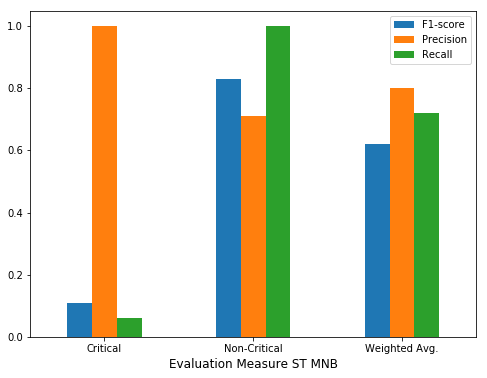

In [20]:
self_training_mnb = get_results('Multinomial Naive Bayes', float)

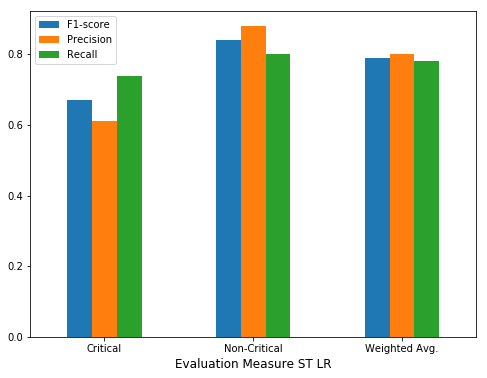

In [14]:
self_training_lr = get_results('Logistic Regression', float)

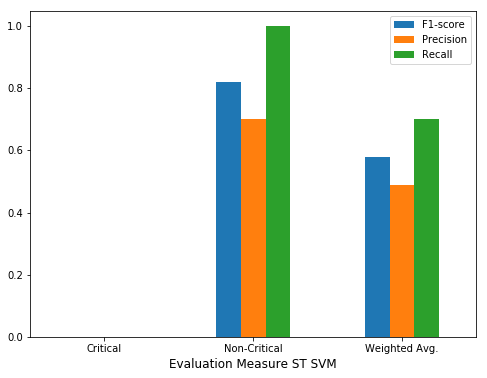

In [18]:
self_training_svm = get_results('SVM', float)

In [28]:
#self_training_mnb = self_training_mnb.rename({'accuracy': 'Self-Training MNB Accuracy', 
#                                                        'f1-score': 'Self-Training MNB f1-score'}, axis=1)
#self_training_svm = self_training_svm.rename({'accuracy': 'Self-Training SVM Accuracy', 
#                                                        'f1-score': 'Self-Training SVM f1-score'}, axis=1)
#self_training_lr = self_training_lr.rename({'accuracy': 'Self-Training Logistic Regression Accuracy', 
#                                                        'f1-score': 'Self-Training Logistic Regression f1-score'}, axis=1)

In [17]:
self_training_mnb = self_training_mnb.rename({0: 'Multinomial Naive Bayes'}, axis=1)
self_training_svm = self_training_svm.rename({0: 'SVMs'}, axis=1)
self_training_lr = self_training_lr.rename({0: 'Logistic Regression'}, axis=1)

In [18]:
st_result = pd.concat([self_training_mnb, self_training_svm, self_training_lr], axis=1)

In [19]:
st_result

,Multinomial Naive Bayes,SVMs,Logistic Regression
Precision,0.80,0.49,0.79
Recall,0.72,0.70,0.78
F1-score,0.62,0.58,0.79
Accuracy,0.72,0.70,0.78


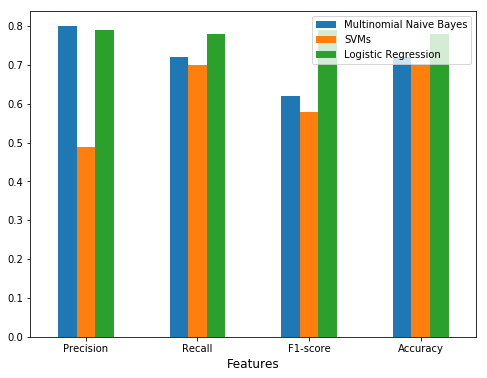

In [20]:
ax = st_result.plot(kind='bar', figsize=(8,6), rot=False)
plt.xlabel('Features', fontsize=12)
plt.savefig('{}_results.pdf'.format('SelfTraining'), dpi=720)

# Get predictions from Logistic Regression Self training for Ensemble

In [44]:
self_training_lr = LogisticRegression(n_jobs=-1, class_weight='balanced')
df = result.copy()

In [45]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words='english')
X_tf = tfidf_vectorizer.fit_transform(df['textual_data']).toarray()
Y_tf = np.array(df['class'])
X_U = X_tf[unlabelled_index]
X_l = X_tf[labelled_index]
Y_l = Y_tf[labelled_index]
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=3, test_size=0.6, random_state=0)
scores = []
iteration = 1
for train_index, test_index in stratified_shuffle_split.split(X_l, Y_l):
    X_train = X_l[train_index].copy()
    Y_train = Y_l[train_index].copy()
    X_test = X_l[test_index].copy()
    Y_test = Y_l[test_index].copy()
    X = np.vstack((X_train, X_U))
    Y_U = np.full((X_U.shape[0], ), -1, dtype=float)
    Y = np.concatenate((Y_train, Y_U)).astype(float)

    slm = SelfLearningModel(self_training_lr)
    slm.fit(X, Y)
    print slm.score(X_test, Y_test.astype(float))

0.728461885431
0.771763644565
0.780784844384


In [46]:
Y_Pred = slm.predict(X_tf)

In [49]:
df['ST_MNB'] = Y_Pred

In [51]:
tsvm_model = joblib.load('models/TSVM_500_3.pkl')

In [ ]:
Y_Pred_tsvm = tsvm_model.predict(X_tf)